In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy
import math
from datetime import datetime
import matplotlib.animation as animation
from PIL import Image
import random
import pandas as pd

In [2]:
epsilon = math.ulp(1.0)

def softmax(x):
    return np.nan_to_num((np.exp(x)+epsilon))/np.nan_to_num((sum(np.exp(x))+epsilon))

def simulate_allstarts(eta,simlen,beta,a,h,noise,H):
    m_log=np.zeros([simlen,P,P])
    x_log=np.zeros([simlen,P,N])
    x_last=np.zeros([N,P])
    projection=((a*xi)+(h*(xi@H))).T # auto+hetero
    for start_node in range(P):
        x=xi[:,start_node]+noise*(np.random.rand(N)-0.5)
        for t in range(simlen):
            r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
            r=softmax(beta*(x@xi))@projection-((1)*(xi_mean.T))
            x+=eta*(r[0]-x)
            m=np.zeros(P)
            for i in range(P):
                m[i] = np.corrcoef(x,xi[:,i])[0,1]
            x_log[t,start_node,:]=x
            m_log[t,start_node,:]=m
        x_last[:,start_node]=x
    autocorr = np.corrcoef(x_last.T) #correlation between attractors

    return (autocorr, m_log, x_log)

def simulate_allstarts_freq(eta,simlen,beta,a,h,freq,noise,H):
    m_log=np.zeros([simlen,P,P])
    x_last=np.zeros([N,P])
    projection=((a*xi)+(h*(xi@H))).T # auto+hetero
    for start_node in range(P):
        x=xi[:,start_node]+noise*(np.random.rand(N)-0.5)
        stim_node=start_node-freq
        for t in range(simlen):
            if (t>1) & (t%freq==0):
                x+=xi[:,stim_node%P]+0.0
                stim_node-=freq
            r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
            x+=eta*(r[0]-x)
            m=np.zeros(P)
            for i in range(P):
                m[i] = np.corrcoef(x,xi[:,i])[0,1]
            m_log[t,:,:]=m
        x_last[:,start_node]=x
    cor_activity=np.corrcoef(x_last.T) #correlation between attractors
    return (m_log, cor_activity)

def get_h(a):
    return 1-a

def get_a(h):
    return h-1

def corr_steps(x_log, xi, steps):
    corrs1 = corr_step(x_log, xi, steps[0])
    corrs2 = corr_step(x_log, xi, steps[1])
    corrs3 = corr_step(x_log, xi, steps[2])
    corrs4 = corr_step(x_log, xi, steps[3])
    return (corrs1, corrs2, corrs3, corrs4)

def corr_step(x_log, xi, step):
    corrs = np.zeros((P,P))
    for x_last in range(0,P):
        for pattern in range(0,P):
            corrs[x_last,pattern] = np.corrcoef(x_log[step,x_last,:],xi[:,pattern])[0][1]
    return corrs

In [3]:
G_circle = nx.cycle_graph(30) # memory graph
H = nx.adjacency_matrix(G_circle) # adjacency matrix
P = len(G_circle.nodes()) # number of patterns
N = 1000 # number of neurons
pos_circle = nx.circular_layout(G_circle, scale=1)

#memories
xi=np.random.rand(N,P)
xi_mean=np.sum(xi, axis=1, keepdims=True)/P
xi_bias=xi-xi_mean

simlen = 100
beta = 1
eta = 0.1
noise = 1

D_diag = np.sum(H,axis=1)
D_diag_half_inv = 1/np.sqrt(np.sum(H,axis=1))
H=np.diag(D_diag_half_inv)@H@np.diag(D_diag_half_inv) # normalized adjacency matrix, $D^{-1/2} A D^{-1/2}$

a1=1
h1=get_h(a1)
autocorr1, m_log1, x_log1 = simulate_allstarts(eta,simlen,beta,a1,h1,noise,H)

a2=0.5
h2=get_h(a2)
autocorr2, m_log2, x_log2 = simulate_allstarts(eta,simlen,beta,a2,h2,noise,H)

a3=-0.5
h3=get_h(a3)
autocorr3, m_log3, x_log3 = simulate_allstarts(eta,simlen,beta,a3,h3,noise,H)

a4=-2
h4=get_h(a4)
autocorr4, m_log4, x_log4 = simulate_allstarts(eta,simlen,beta,a4,h4,noise,H)

C:\Users\Thomas Burns\AppData\Local\Temp\ipykernel_19944\3978413052.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


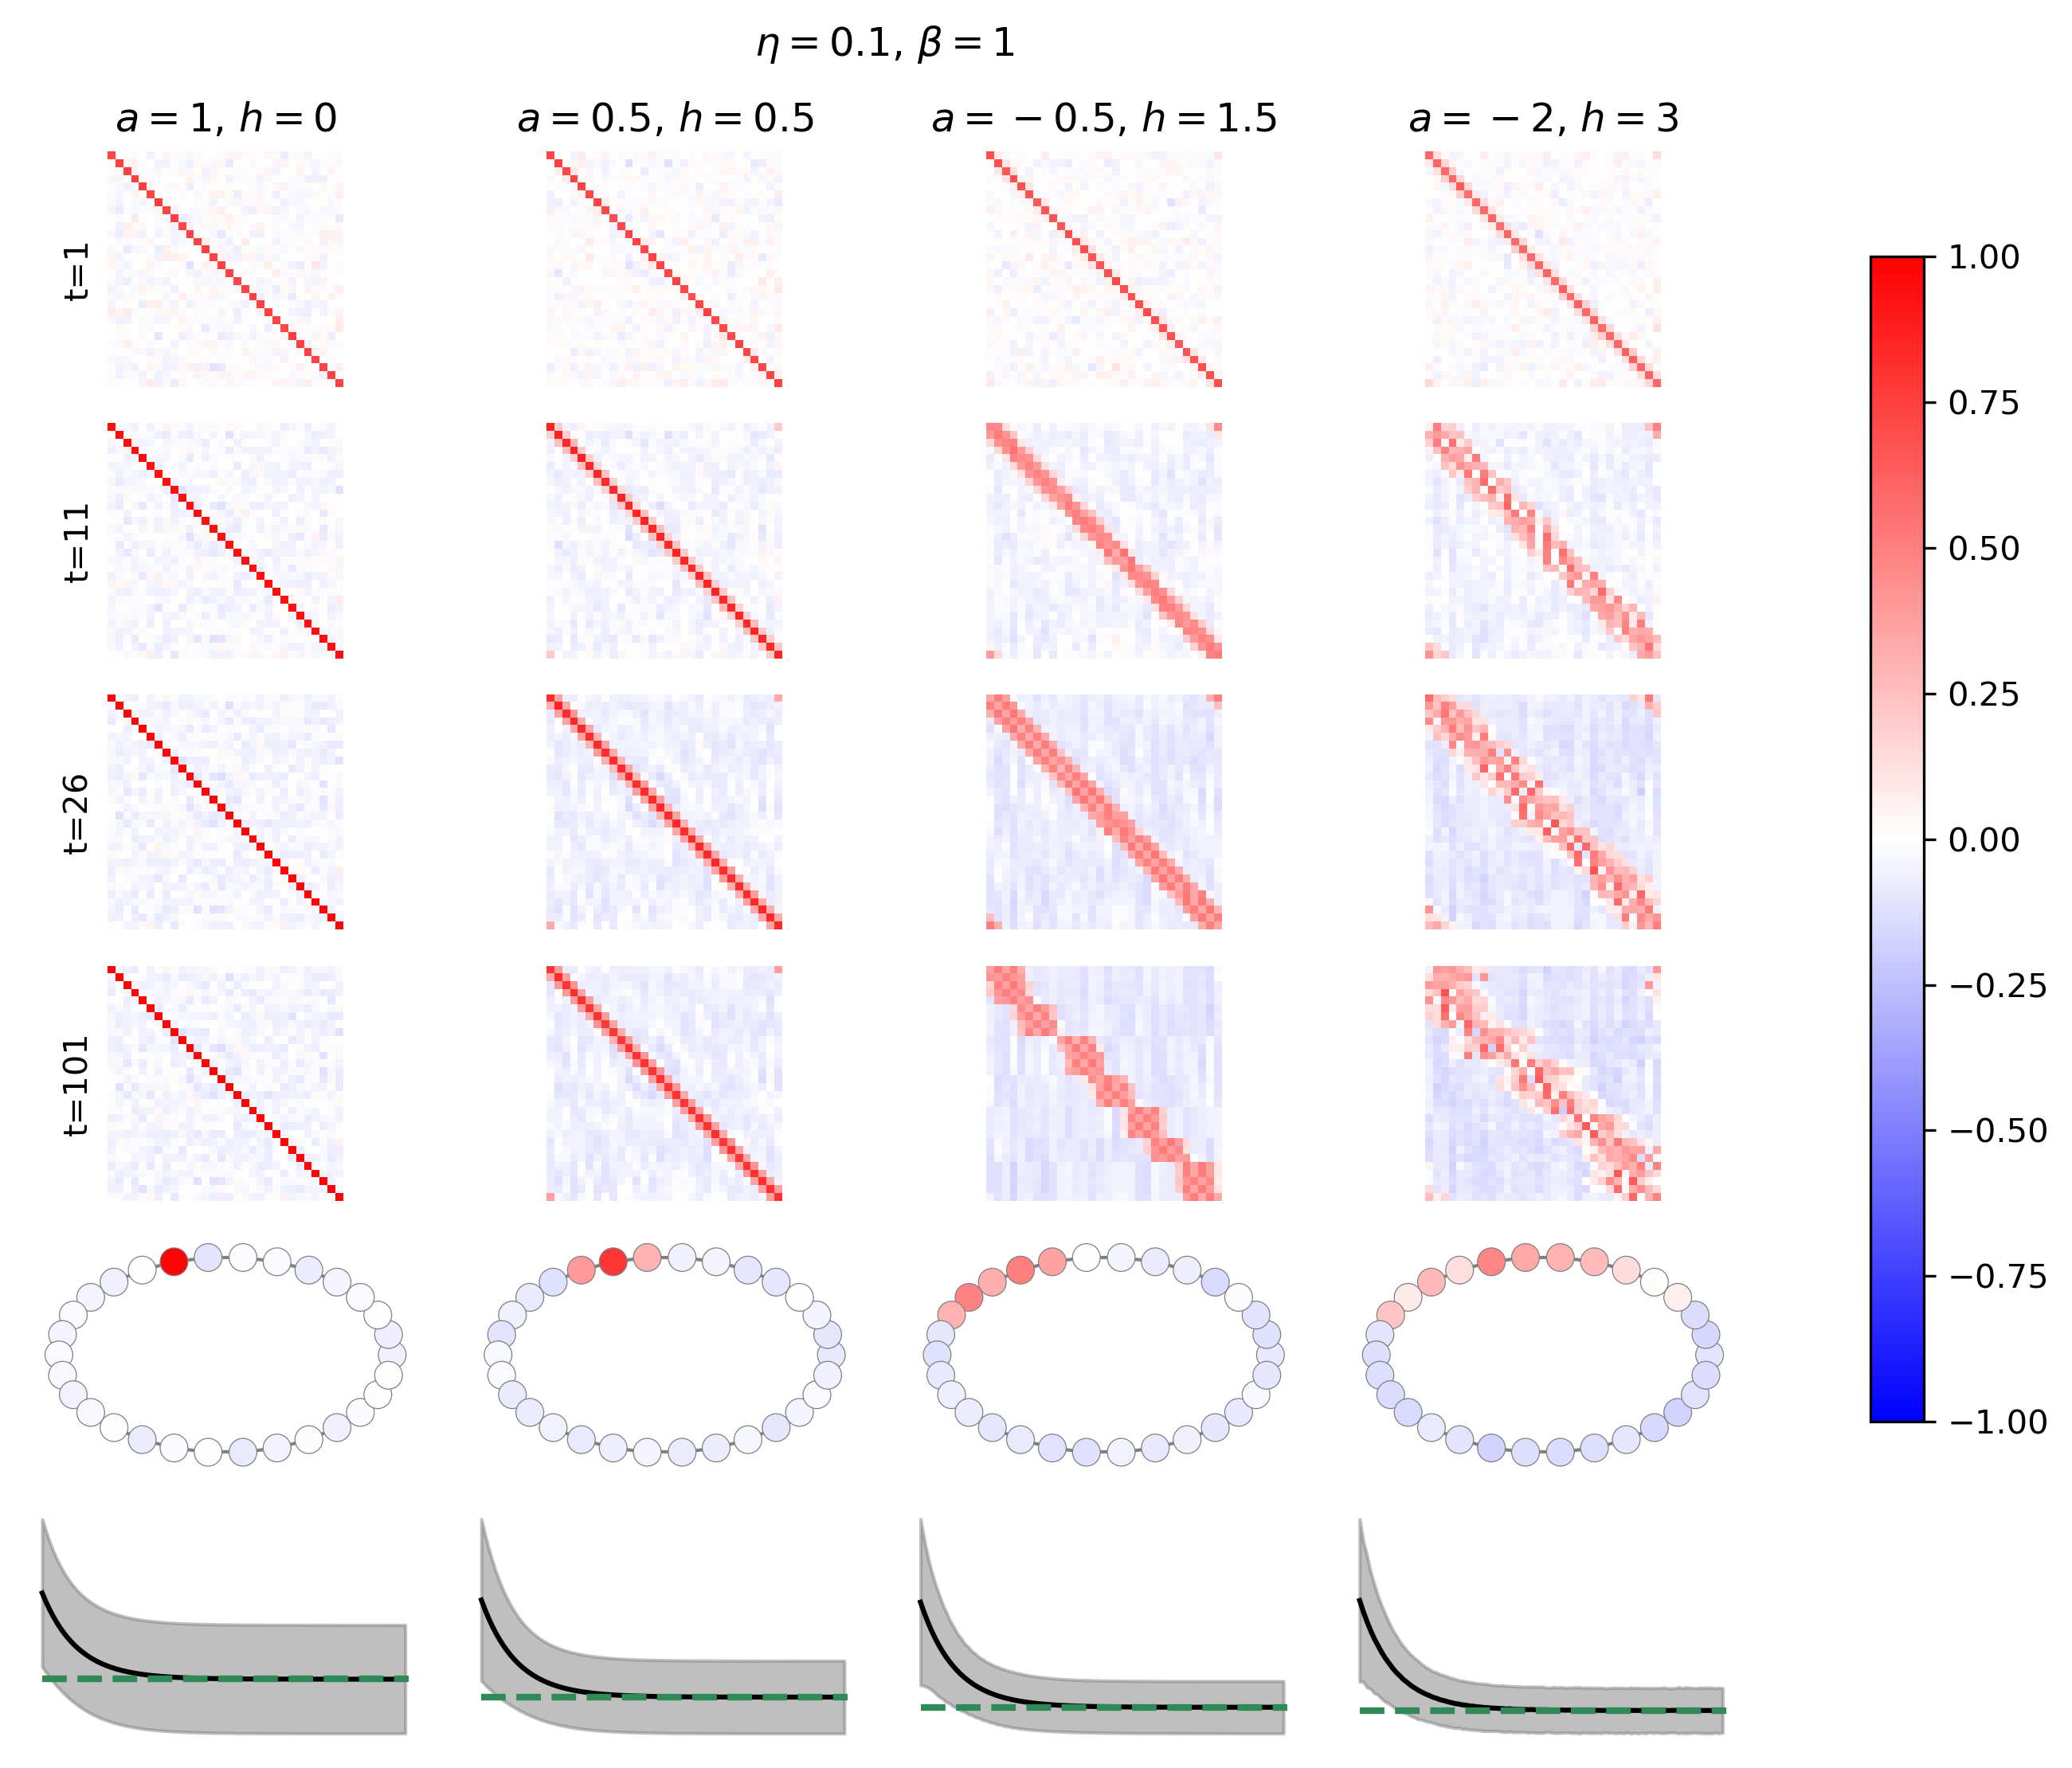

In [4]:
timesteps_to_plot = [0,10,25,-1]
corrs11, corrs12, corrs13, corrs14 = corr_steps(x_log1, xi, timesteps_to_plot)
corrs21, corrs22, corrs23, corrs24 = corr_steps(x_log2, xi, timesteps_to_plot)
corrs31, corrs32, corrs33, corrs34 = corr_steps(x_log3, xi, timesteps_to_plot)
corrs41, corrs42, corrs43, corrs44 = corr_steps(x_log4, xi, timesteps_to_plot)

# mean neural activity (x) across updates
x = np.linspace(0, simlen-1, simlen)
mean1 = np.mean(x_log1,axis=(1,2))
std1 = np.std(x_log1,axis=(1,2))
mean2 = np.mean(x_log2,axis=(1,2))
std2 = np.std(x_log2,axis=(1,2))
mean3 = np.mean(x_log3,axis=(1,2))
std3 = np.std(x_log3,axis=(1,2))
mean4 = np.mean(x_log4,axis=(1,2))
std4 = np.std(x_log4,axis=(1,2))

fig, axs = plt.subplots(6, 4, squeeze=False, figsize=(7.5, 7.5), dpi=300)
stim_node = 9
node_sizes = 70

axs[0, 0].title.set_text('$a='+str(a1)+'$, $h='+str(h1)+'$')#, fontsize=50)
im11 = axs[0, 0].imshow(corrs11, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
im12 = axs[1, 0].imshow(corrs12, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
im13 = axs[2, 0].imshow(corrs13, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
im14 = axs[3, 0].imshow(corrs14, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 0].set_ylabel('t='+str(timesteps_to_plot[0]+1))
axs[1, 0].set_ylabel('t='+str(timesteps_to_plot[1]+1))
axs[2, 0].set_ylabel('t='+str(timesteps_to_plot[2]+1))
axs[3, 0].set_ylabel('t='+str(simlen+1))

axs[0, 0].xaxis.set_visible(False) # make xaxis invisible
axs[1, 0].xaxis.set_visible(False)
axs[2, 0].xaxis.set_visible(False)
axs[3, 0].xaxis.set_visible(False)
plt.setp(axs[0, 0].spines.values(), visible=False) # make spines (the box) 
plt.setp(axs[1, 0].spines.values(), visible=False)
plt.setp(axs[2, 0].spines.values(), visible=False)
plt.setp(axs[3, 0].spines.values(), visible=False)
axs[0, 0].tick_params(left=False, labelleft=False) # remove ticks and labels for the left axis
axs[1, 0].tick_params(left=False, labelleft=False)
axs[2, 0].tick_params(left=False, labelleft=False)
axs[3, 0].tick_params(left=False, labelleft=False)

nx.draw(G_circle, pos=pos_circle, ax=axs[4, 0], node_color=corrs14[stim_node,:], node_size=node_sizes,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')

axs[5, 0].plot(mean1, color='black')
axs[5, 0].fill_between(x, mean1-std1, mean1+std1, color='gray', alpha=0.5)
axs[5, 0].axis('off')

axs[0, 1].title.set_text('$a='+str(a2)+'$, $h='+str(h2)+'$')
im21 = axs[0, 1].imshow(corrs21, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
im22 = axs[1, 1].imshow(corrs22, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
im23 = axs[2, 1].imshow(corrs23, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
im24 = axs[3, 1].imshow(corrs24, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 1].axis('off')
axs[1, 1].axis('off')
axs[2, 1].axis('off')
axs[3, 1].axis('off')

nx.draw(G_circle, pos=pos_circle, ax=axs[4, 1], node_color=corrs24[stim_node,:], node_size=node_sizes,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')
axs[5, 1].plot(mean2, color='black')
axs[5, 1].fill_between(x, mean2-std2, mean2+std2, color='gray', alpha=0.5)
axs[5, 1].axis('off')

axs[0, 2].title.set_text('$a='+str(a3)+'$, $h='+str(h3)+'$')
im31 = axs[0, 2].imshow(corrs31, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
im32 = axs[1, 2].imshow(corrs32, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
im33 = axs[2, 2].imshow(corrs33, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
im34 = axs[3, 2].imshow(corrs34, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 2].axis('off')
axs[1, 2].axis('off')
axs[2, 2].axis('off')
axs[3, 2].axis('off')

nx.draw(G_circle, pos=pos_circle, ax=axs[4, 2], node_color=corrs34[stim_node,:], node_size=node_sizes,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')
axs[5, 2].plot(mean3, color='black')
axs[5, 2].fill_between(x, mean3-std3, mean3+std3, color='gray', alpha=0.5)
axs[5, 2].axis('off')

axs[0, 3].title.set_text('$a='+str(a4)+'$, $h='+str(h4)+'$')
im41 = axs[0, 3].imshow(corrs41, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
im42 = axs[1, 3].imshow(corrs42, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
im43 = axs[2, 3].imshow(corrs43, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
im44 = axs[3, 3].imshow(corrs44, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 3].axis('off')
axs[1, 3].axis('off')
axs[2, 3].axis('off')
axs[3, 3].axis('off')

nx.draw(G_circle, pos=pos_circle, ax=axs[4, 3], node_color=corrs44[stim_node,:], node_size=node_sizes,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')
axs[5, 3].plot(mean4, color='black')
axs[5, 3].fill_between(x, mean4-std4, mean4+std4, color='gray', alpha=0.5)
axs[5, 3].axis('off')

line_colour = 'seagreen'
axs[5, 0].hlines(y=0, xmin=0, xmax=simlen, colors=line_colour, linestyles='--', lw=2)
axs[5, 1].hlines(y=0, xmin=0, xmax=simlen, colors=line_colour, linestyles='--', lw=2)
axs[5, 2].hlines(y=0, xmin=0, xmax=simlen, colors=line_colour, linestyles='--', lw=2)
axs[5, 3].hlines(y=0, xmin=0, xmax=simlen, colors=line_colour, linestyles='--', lw=2)

now = np.datetime64(datetime.now())

cbar_ax = fig.add_axes([1.05, 0.2, 0.03, 0.65])
fig.colorbar(im11, cax=cbar_ax)
plt.suptitle('$\eta='+str(eta)+'$, $\\beta='+str(beta)+'$')
plt.tight_layout()
# plt.savefig("correlations_circle_test_"+str((now.astype('uint64') / 1e6).astype('uint32'))+".pdf", format="pdf", bbox_inches="tight")
plt.show()

C:\Users\Thomas Burns\AppData\Local\Temp\ipykernel_19944\2907121676.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


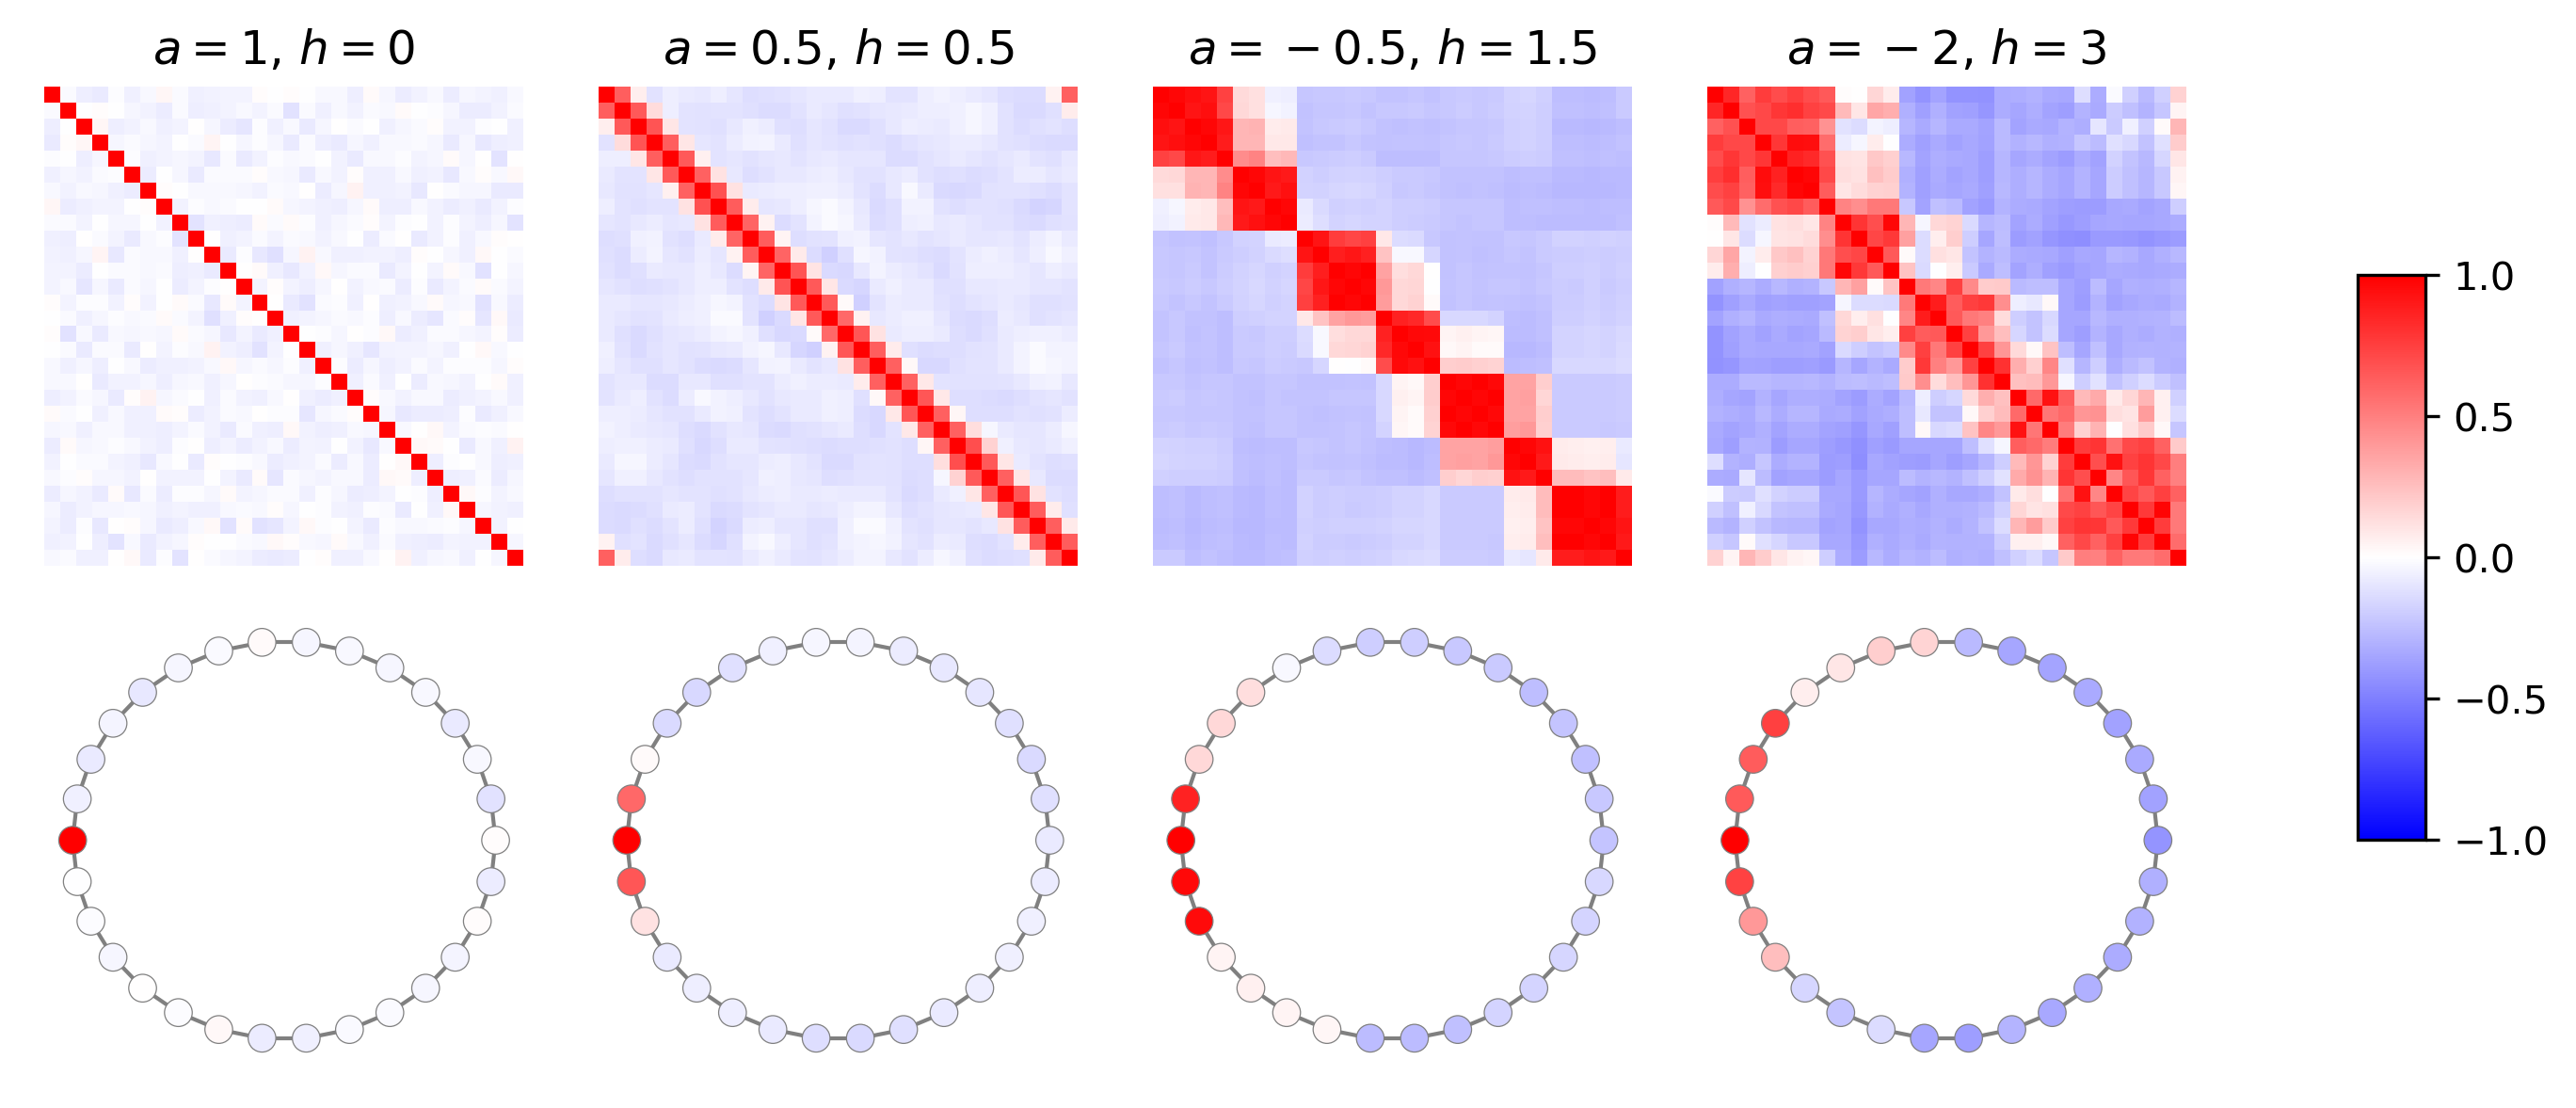

In [5]:
fig, axs = plt.subplots(2, 4, dpi=300, squeeze=False, figsize=(8, 4))
stim_node = 15

axs[0, 0].title.set_text('$a='+str(a1)+'$, $h='+str(h1)+'$')
im1 = axs[0, 0].imshow(autocorr1, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 0].axis('off')
nx.draw(G_circle, pos=pos_circle, ax=axs[1, 0], node_color=autocorr1[stim_node,:], node_size=50,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')

axs[0, 1].title.set_text('$a='+str(a2)+'$, $h='+str(h2)+'$')
im2 = axs[0, 1].imshow(autocorr2, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 1].axis('off')
nx.draw(G_circle, pos=pos_circle, ax=axs[1, 1], node_color=autocorr2[stim_node,:], node_size=50,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')

axs[0, 2].title.set_text('$a='+str(a3)+'$, $h='+str(h3)+'$')
im3 = axs[0, 2].imshow(autocorr3, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 2].axis('off')
nx.draw(G_circle, pos=pos_circle, ax=axs[1, 2], node_color=autocorr3[stim_node,:], node_size=50,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')

axs[0, 3].title.set_text('$a='+str(a4)+'$, $h='+str(h4)+'$')
im4 = axs[0, 3].imshow(autocorr4, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 3].axis('off')
nx.draw(G_circle, pos=pos_circle, ax=axs[1, 3], node_color=autocorr4[stim_node,:], node_size=50,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')

cbar_ax = fig.add_axes([1.05, 0.25, 0.03, 0.50])
fig.colorbar(im2, cax=cbar_ax)
plt.tight_layout()
plt.savefig("autocorrelations_circle_test_"+str((now.astype('uint64') / 1e6).astype('uint32'))+".pdf", format="pdf", bbox_inches="tight")
plt.show()

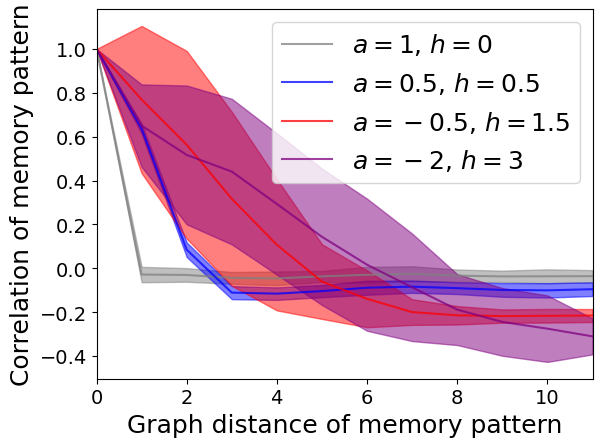

In [6]:
distance_corr_len = 12
distance_corrs1 = np.zeros((distance_corr_len, len(autocorr1[0])))
for i in range(distance_corr_len):
    rolling_corr1 = np.roll(autocorr1, i, axis=1)
    distance_corrs1[i,:] = np.diagonal(rolling_corr1)
    
distance_corrs2 = np.zeros((distance_corr_len, len(autocorr2[0])))
for i in range(distance_corr_len):
    rolling_corr2 = np.roll(autocorr2, i, axis=1)
    distance_corrs2[i,:] = np.diagonal(rolling_corr2)

distance_corrs3 = np.zeros((distance_corr_len, len(autocorr3[0])))
for i in range(distance_corr_len):
    rolling_corr3 = np.roll(autocorr3, i, axis=1)
    distance_corrs3[i,:] = np.diagonal(rolling_corr3)

distance_corrs4 = np.zeros((distance_corr_len, len(autocorr4[0])))
for i in range(distance_corr_len):
    rolling_corr4 = np.roll(autocorr4, i, axis=1)
    distance_corrs4[i,:] = np.diagonal(rolling_corr4)
    
mean1 = np.mean(distance_corrs1,axis=1)
std1 = np.std(distance_corrs1,axis=1)
sem1 = std1/np.sqrt(P)
mean2 = np.mean(distance_corrs2,axis=1)
std2 = np.std(distance_corrs2,axis=1)
sem2 = std2/np.sqrt(P)
mean3 = np.mean(distance_corrs3,axis=1)
std3 = np.std(distance_corrs3,axis=1)
sem3 = std3/np.sqrt(P)
mean4 = np.mean(distance_corrs4,axis=1)
std4 = np.std(distance_corrs4,axis=1)
sem4 = std4/np.sqrt(P)

x = np.linspace(0, 11, 12)
plt.plot(mean1, color='gray', label='$a='+str(a1)+'$, $h='+str(h1)+'$', alpha=0.75)
plt.fill_between(x, mean1-std1, mean1+std1, color='gray', alpha=0.5)
plt.plot(mean2, color='blue', label='$a='+str(a2)+'$, $h='+str(h2)+'$', alpha=0.75)
plt.fill_between(x, mean2-std2, mean2+std2, color='blue', alpha=0.5)
plt.plot(mean3, color='red', label='$a='+str(a3)+'$, $h='+str(h3)+'$', alpha=0.75)
plt.fill_between(x, mean3-std3, mean3+std3, color='red', alpha=0.5)
plt.plot(mean4, color='purple', label='$a='+str(a4)+'$, $h='+str(h4)+'$', alpha=0.75)
plt.fill_between(x, mean4-std4, mean4+std4, color='purple', alpha=0.5)
plt.xlabel("Graph distance of memory pattern", fontsize=18)
plt.ylabel("Correlation of memory pattern", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,11)
plt.legend(fontsize=18)
plt.savefig("correlations_circle_range-mean-std_"+str((now.astype('uint64') / 1e6).astype('uint32'))+".pdf", format="pdf", bbox_inches="tight")
plt.show()